# Survey Data with Pandas and StatsModels

Tutorial for PyCon 2025

Allen B. Downey

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPandas/blob/main/notebooks/01_simpson.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configure Matplotlib

plt.rcParams["figure.figsize"] = 7, 3.5
plt.rcParams["figure.dpi"] = 75
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    legend = options.pop("legend", True)
    loc = options.pop("loc", "best")

    # Pass options to Axis.set
    ax = plt.gca()
    ax.set(**options)

    # Add a legend if there are any labeled elements
    handles, labels = ax.get_legend_handles_labels()
    if handles and legend:
        ax.legend(handles, labels, loc=loc)

    # Tight layout is generally a good idea
    plt.tight_layout()

## Data

We will use data from the [General Social Survey](https://gss.norc.org/) (GSS).
The raw dataset is big, so I've prepared an extract, which the following cell downloads.
The code to generate the extract is [in this notebook](https://github.com/AllenDowney/GssExtract/blob/main/notebooks/02_make_extract-2022_4.ipynb).

In [5]:
# This dataset is prepared in the GssExtract repository

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"

filename = "gss_extract_pacs_workshop.hdf"
download(DATA_PATH + filename)

In [6]:
# Solution

gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 29)

In [7]:
# Solution

gss.head()

,age,attend,ballot,class,cohort,degree,educ,fair,fear,goodlife,...,region,relig,rincome,satfin,satjob,sex,srcbelt,trust,wtssall,year
0,24.0,1.0,NaN,3.0,1948.0,3.0,16.0,2.0,NaN,NaN,...,1,1.0,NaN,1.0,NaN,1.0,5.0,1.0,1.3339,1972
1,33.0,2.0,NaN,2.0,1939.0,0.0,10.0,2.0,NaN,NaN,...,1,2.0,NaN,3.0,2.0,1.0,1.0,1.0,0.8893,1972
2,40.0,8.0,NaN,2.0,1932.0,1.0,12.0,2.0,NaN,NaN,...,1,5.0,NaN,1.0,NaN,2.0,3.0,2.0,1.3339,1972
3,24.0,2.0,NaN,2.0,1948.0,1.0,12.0,1.0,NaN,NaN,...,9,2.0,NaN,2.0,NaN,1.0,3.0,2.0,1.7786,1972
4,21.0,7.0,NaN,3.0,1951.0,1.0,12.0,1.0,NaN,NaN,...,9,1.0,NaN,1.0,NaN,2.0,2.0,NaN,1.7786,1972


In [8]:
# Solution

gss.columns

Index(['age', 'attend', 'ballot', 'class', 'cohort', 'degree', 'educ', 'fair',
       'fear', 'goodlife', 'hapmar', 'happy', 'health', 'helpful', 'id',
       'life', 'partyid', 'polviews', 'race', 'region', 'relig', 'rincome',
       'satfin', 'satjob', 'sex', 'srcbelt', 'trust', 'wtssall', 'year'],
      dtype='object')

In [9]:
# Solution

gss.isna().mean().sort_values()

id          0.000000
year        0.000000
wtssall     0.000000
region      0.000000
srcbelt     0.000718
race        0.001796
sex         0.002086
degree      0.002942
educ        0.004338
cohort      0.005567
relig       0.007087
partyid     0.007294
attend      0.009711
age         0.010416
class       0.048501
satfin      0.063641
happy       0.065106
polviews    0.131620
health      0.236552
satjob      0.265064
ballot      0.302183
fear        0.365147
life        0.386669
rincome     0.402086
trust       0.410982
helpful     0.414090
fair        0.415665
hapmar      0.468241
goodlife    0.631924
dtype: float64

## Distributions

We'll see two ways to describe distributions: value counts and KDE.

And for joint distributions, we'll use a cross tabulation.

In [10]:
def value_counts(seq, **options):
    """Make a series of values and the number of times they appear.

    Args:
        seq: sequence

    returns: Pandas Series
    """
    return pd.Series(seq).value_counts(**options).sort_index()

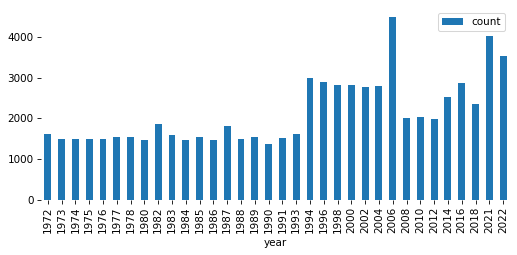

In [103]:
# Solution

pmf = value_counts(gss['year'])
pmf.plot(kind='bar')
decorate()

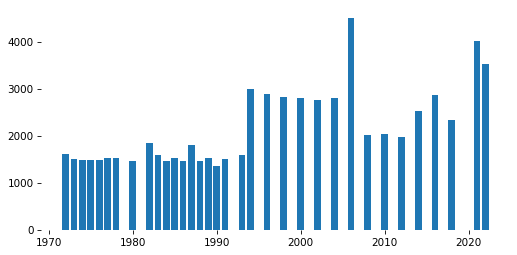

In [104]:
# Solution

x, y = pmf.index, pmf.values
plt.bar(x, y)
decorate()

In [12]:
# Solution

gss['age'].describe()

count    71636.000000
mean        44.985943
std         17.201666
min         18.000000
25%         30.000000
50%         43.000000
75%         58.000000
max         89.000000
Name: age, dtype: float64

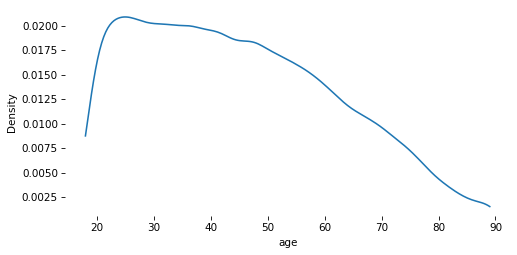

In [13]:
# Solution

sns.kdeplot(gss['age'], cut=0)
decorate()

In [14]:
# Solution

gss['cohort'].describe()

count    71987.000000
mean      1991.908095
std        561.717010
min       1883.000000
25%       1938.000000
50%       1954.000000
75%       1968.000000
max       9999.000000
Name: cohort, dtype: float64

In [15]:
# Solution

gss['cohort'] = gss['cohort'].replace(9999, np.nan)

### Exercise

Use `value_counts` to plot the distribution of `cohort` as a bar plot.
Then use `sns.kdeplot` to show the same distribution as a continuous quantity.

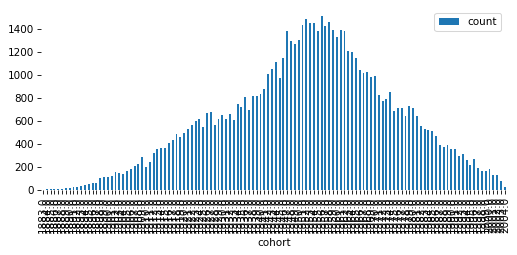

In [101]:
# Solution

pmf = value_counts(gss['cohort'])
pmf.plot(kind='bar')
decorate(ylabel='Count')

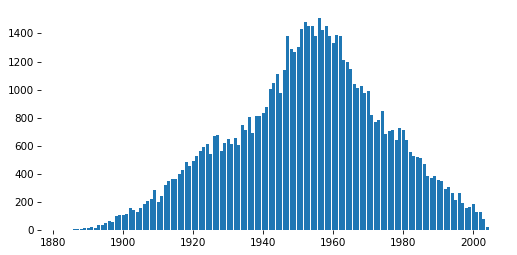

In [102]:
# Solution

x, y = pmf.index, pmf.values
plt.bar(x, y)
decorate(ylabel='Count')

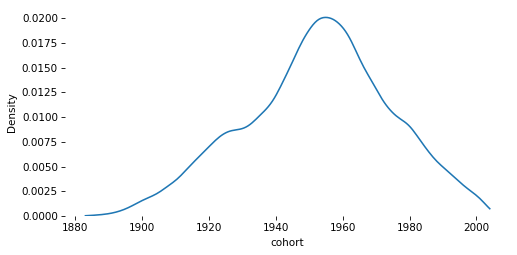

In [16]:
# Solution

sns.kdeplot(gss['cohort'], cut=0)
decorate()

## Cross tabulation

Cross tabulation is a way to represent the joint distribution of two variables.

In [95]:
# Solution

xtab = pd.crosstab(gss['cohort'], gss['age'])
xtab

age,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,...,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0
cohort,,,,,,,,,,,,,,,,,,,,,
1883.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1884.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1885.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1886.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
1887.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000.0,36,0,0,71,77,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2001.0,0,0,68,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002.0,0,59,69,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


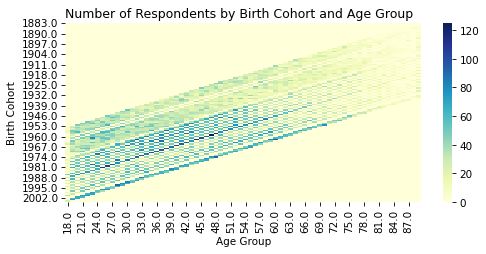

In [100]:
# Solution

sns.heatmap(
    xtab,
    cmap="YlGnBu",
)

plt.title("Number of Respondents by Birth Cohort and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Birth Cohort")
decorate()

## Target variable

I've selected four variables you might want to work with.
Whichever one you choose, put its cell last.

In [19]:
# https://gssdataexplorer.norc.org/variables/434/vshow

varname = 'happy'

question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

responses = ['Very happy', "Happy", 'Not too happy']

ylabel = "Percent saying 'very happy'"

In [20]:
# https://gssdataexplorer.norc.org/variables/439/vshow

varname = 'helpful'

question = """Would you say that most of the time people try to be helpful,
or that they are mostly just looking out for themselves?
"""

responses = ['Helpful', 'Look out\nfor themselves', 'Depends']

ylabel = "Percent saying 'helpful'"

In [21]:
# https://gssdataexplorer.norc.org/variables/440/vshow

varname = 'fair'

question = """Do you think most people would try to take advantage of you 
if they got a chance, or would they try to be fair?
"""

# notice that the negative response is first here!
responses = ['Take advantage', 'Fair', 'Depends']

ylabel = "Percent saying 'fair'"

In [22]:
# https://gssdataexplorer.norc.org/variables/441/vshow

varname = 'trust'

question = """Generally speaking, would you say that most people can be trusted
or that you can't be too careful in dealing with people?
"""

responses = ['Trusted', "Can't be\ntoo careful", 'Depends']

ylabel = "Percent saying 'trusted'"

In [23]:
# Solution

column = gss[varname]
column

0        1.0
1        1.0
2        2.0
3        2.0
4        NaN
        ... 
72385    2.0
72386    2.0
72387    NaN
72388    NaN
72389    1.0
Name: trust, Length: 72390, dtype: float64

In [24]:
# Solution

value_counts(column, dropna=False)

trust
1.0    15783
2.0    24890
3.0     1966
NaN    29751
Name: count, dtype: int64

In [25]:
# Solution

pmf = value_counts(column, normalize=True)
pmf

trust
1.0    0.370154
2.0    0.583738
3.0    0.046108
Name: proportion, dtype: float64

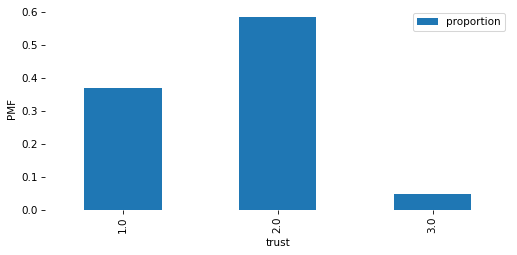

In [26]:
# Solution

pmf.plot(kind='bar')
decorate(ylabel='PMF')

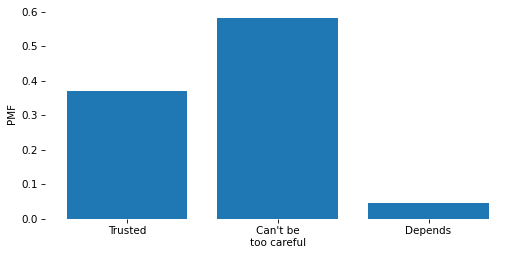

In [27]:
# Solution

plt.bar(pmf.index, pmf)
plt.xticks(pmf.index, responses)

decorate(ylabel='PMF')

### Exercise

Do you think people who say "trust" are also more likely to say "helpful"?
To find out, make a cross tabulation of `trust` and `helpful`.
Consider using `normalize='index'`.
Make a heatmap that shows this joint distribution.
What relationships can you see in the responses?

In [93]:
# Solution

xtab = pd.crosstab(gss['trust'], gss['helpful'], normalize='index')
xtab

helpful,1.0,2.0,3.0
trust,,,
1.0,0.707773,0.243133,0.049094
2.0,0.340947,0.592560,0.066493
3.0,0.417197,0.283970,0.298832


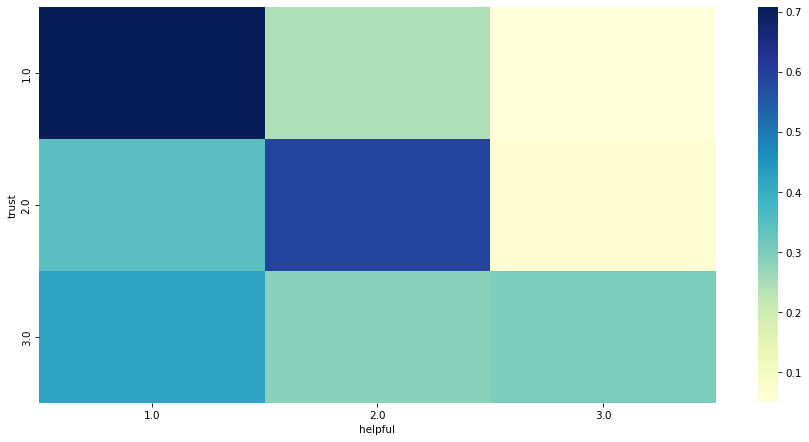

In [94]:
# Solution

plt.figure(figsize=(12, 6))
sns.heatmap(
    xtab,
    cmap="YlGnBu",
)

decorate(xlabel='helpful', ylabel='trust')

## Time Series

To see how responses have changed over time, we'll use cross tabulation again.

In [28]:
# Solution

xtab = pd.crosstab(gss["year"], gss[varname], normalize='index')
xtab.head()

trust,1.0,2.0,3.0
year,,,
1972,0.463551,0.490343,0.046106
1973,0.483656,0.495664,0.020680
1975,0.391099,0.564396,0.044504
1976,0.455518,0.513043,0.031438
1978,0.396597,0.549738,0.053665


In [29]:
# Solution

gss72 = gss.query('year == 1972')
gss72.shape

(1613, 29)

In [30]:
# Solution

pmf72 = value_counts(gss72[varname], normalize=True)
pmf72

trust
1.0    0.463551
2.0    0.490343
3.0    0.046106
Name: proportion, dtype: float64

In [31]:
# Solution

time_series = xtab[1] * 100
time_series.name = "data"

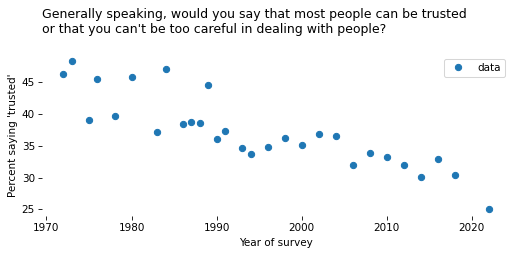

In [32]:
# Solution

time_series.plot(style='o')
decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

## Smoothing

To smooth the time series, we'll use LOWESS (locally weighted scatterplot smoothing).

In [105]:
# Solution

x = time_series.index.to_numpy()
y = time_series.to_numpy()

In [107]:
# Solution

from statsmodels.nonparametric.smoothers_lowess import lowess

smooth_array = lowess(y, x)

In [35]:
# Solution

index, data = np.transpose(smooth_array)
smooth_series = pd.Series(data, index=index)

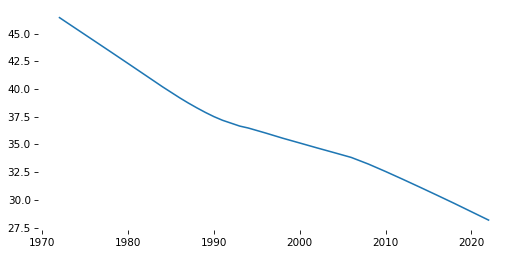

In [36]:
# Solution

smooth_series.plot()
decorate()

In [37]:
def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.to_numpy()
    x = series.index.to_numpy()

    smooth_array = lowess(y, x, frac)
    index, data = np.transpose(smooth_array)

    return pd.Series(data, index=index)

### Exercise

Use this function to make `smooth_series`.
Plot the result along with `time_series`.

In [38]:
# Solution

smooth_series = make_lowess(time_series)

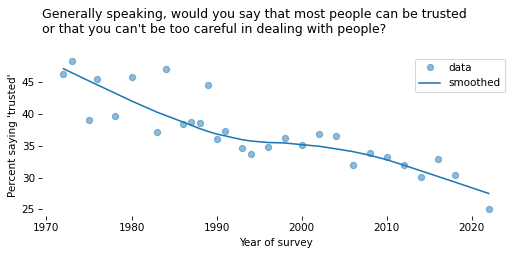

In [39]:
# Solution

time_series.plot(style='o', alpha=0.5)
smooth_series.plot(label='smoothed', color='C0')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

## Binary series

It will be useful to convert the responses to a binary variable represented with 0s and 1s.

In [40]:
# Solution

# tempting but wrong

gss['y'] = gss[varname] == 1
value_counts(gss['y'], dropna=False)

y
False    56607
True     15783
Name: count, dtype: int64

In [41]:
# Solution

gss['y'] = np.where(gss[varname].notna(), gss[varname] == 1, np.nan)
value_counts(gss['y'], dropna=False)

y
0.0    26856
1.0    15783
NaN    29751
Name: count, dtype: int64

In [42]:
# Solution

# Reminder: this needs to be updated depending on the target variable

gss['y'] = gss[varname].replace([1, 2, 3], [1, 0, 0])
value_counts(gss['y'], dropna=False)

y
0.0    26856
1.0    15783
NaN    29751
Name: count, dtype: int64

## Pivot tables

Now we'll use a pivot table to put respondents in groups and see how the responses have changed over time.

In [43]:
polviews_map = {
    1: 'Liberal',
    2: 'Liberal',
    3: 'Liberal',
    4: 'Moderate',
    5: 'Conservative',
    6: 'Conservative',
    7: 'Conservative',
}

In [44]:
# Solution

gss['polviews3'] = gss['polviews'].replace(polviews_map)

In [45]:
# Solution

value_counts(gss['polviews3'], dropna=False)

polviews3
Conservative    21580
Liberal         17370
Moderate        23912
NaN              9528
Name: count, dtype: int64

In [46]:
# Solution

table = gss.pivot_table(
    index='year', columns='polviews3', values='y', aggfunc='mean'
) * 100
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1975,41.891892,39.192399,38.733706
1976,49.590164,45.961003,44.561404
1978,42.699115,43.262411,37.347295
1980,47.609562,45.896657,46.204620
1983,41.935484,31.914894,39.240506


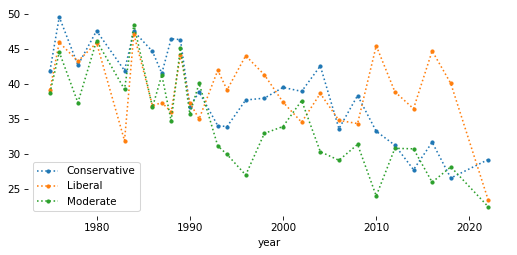

In [47]:
# Solution

table.plot(style='.:')
decorate()

## Better colors

We'll select colors from a Seaborn color palette.

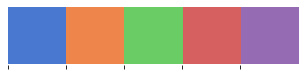

In [48]:
# Solution

muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [49]:
# Solution

color_map = {
    'Conservative': muted[3], 
    'Moderate': muted[4], 
    'Liberal': muted[0]
}

### Exercise

Loop through the groups in `color_map`.
For each one, extract a column from `table` and plot the data points; then plot a smooth line.

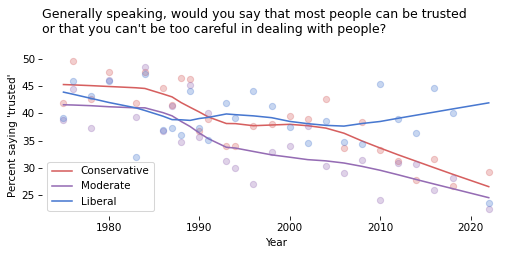

In [108]:
# Solution

for group in color_map:
    series = table[group]
    color = color_map[group]
    series.plot(style='o', label='', color=color, alpha=0.3)
    smooth = make_lowess(series)
    smooth.plot(label=group, color=color)

decorate(
    xlabel='Year',
    ylabel=ylabel,
    title=question,
)

## Groupby

Now that we have `y` as a binary variable, we have another way to compute the time series and the pivot table.
There are pros and cons of each method.

In [109]:
# Solution

valid = gss.dropna(subset=['y'])

In [111]:
# Solution

time_series2 = valid.groupby('year')['y'].mean() * 100
assert np.allclose(time_series, time_series2)

In [53]:
# Solution

table2 = valid.groupby(['year', 'polviews3'])['y'].mean().unstack() * 100
assert np.allclose(table, table2)

## Logistic regression

We'll use logistic regression to model changes over time.

In [54]:
# Solution

year_shift = gss['year'].median()
gss['x'] = gss['year'] - year_shift

In [55]:
# Solution

subset = gss.dropna(subset=['y', 'x'])

In [56]:
# Solution

import statsmodels.formula.api as smf

formula = 'y ~ x + I(x**2)'

model = smf.logit(formula, data=subset).fit(disp=False)
model.params

Intercept   -0.588941
x           -0.014565
I(x ** 2)    0.000057
dtype: float64

In [57]:
# Solution

year_range = np.arange(1972, 2026)

pred_df = pd.DataFrame(dict(x=year_range - year_shift))

pred_series = model.predict(pred_df) * 100
pred_series.index = year_range

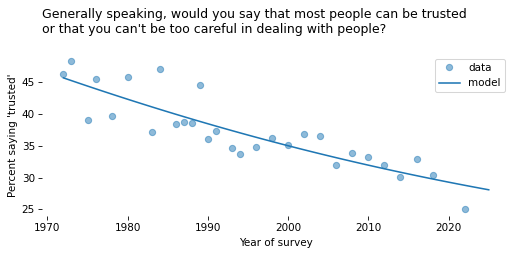

In [58]:
# Solution

time_series.plot(style='o', alpha=0.5)
pred_series.plot(label='model', color='C0')

decorate(
    xlabel="Year of survey",
    ylabel=ylabel,
    title=question,
)

In [59]:
def fit_model(data, x_range, x_shift):
    formula = 'y ~ x + I(x**2)'
    model = smf.logit(formula, data=data).fit(disp=False)
    
    pred_df = pd.DataFrame(dict(x=x_range - x_shift))
    pred = model.predict(pred_df) * 100
    pred.index = x_range
    pred.name = 'model'

    return pred

In [60]:
# Solution

pred_series2 = fit_model(subset, year_range, year_shift)
assert np.allclose(pred_series, pred_series2)

### Exercise

Use `subset.groupby('polviews3')` to loop through the groups.
For each one, use `fit_model` to generate and plot a "prediction" for the group.

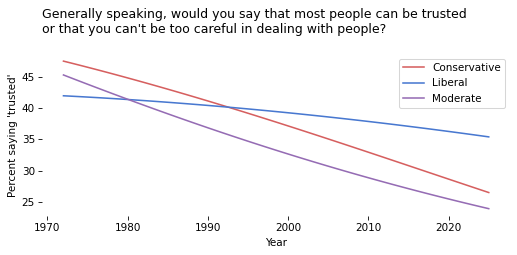

In [61]:
# Solution

for name, group in subset.groupby('polviews3'):
    pred_series = fit_model(group, year_range, year_shift)
    pred_series.plot(label=name, color=color_map[name])
    
decorate(
    xlabel='Year',
    ylabel=ylabel,
    title=question,
)

## Group by cohort

Now let's group respondents by decade of birth and see how each cohort changes over time.


In [62]:
def round_into_bins(series, bin_width, low=0, high=None):
    """Rounds values down to the bin they belong in.

    series: pd.Series
    bin_width: number, width of the bins

    returns: Series of bin values (with NaN preserved)
    """
    if high is None:
        high = series.max()

    bins = np.arange(low, high + bin_width, bin_width)
    indices = np.digitize(series, bins)
    result = pd.Series(bins[indices - 1], index=series.index, dtype='float')

    result[series.isna()] = np.nan
    return result

In [63]:
# Solution

gss["cohort10"] = round_into_bins(gss["cohort"], 10, 1880)
value_counts(gss["cohort10"], dropna=False)

cohort10
1880.0       45
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
2000.0      545
NaN         755
Name: count, dtype: int64

In [64]:
# Solution

cohort_df = gss.query("cohort10 == 1940").dropna(subset=['y', 'x'])
cohort_df.shape

(6825, 33)

In [65]:
# Solution

cohort_series = cohort_df.groupby('year')['y'].mean() * 100
cohort_series.name = '1940 cohort'

In [66]:
# Solution

x_range = cohort_series.index
pred_series = fit_model(cohort_df, x_range, year_shift)

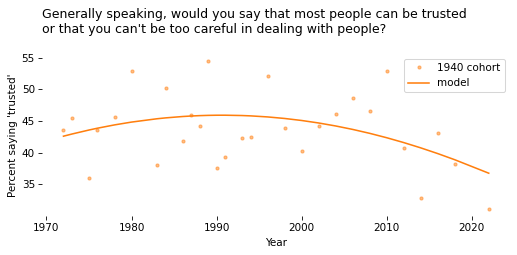

In [67]:
# Solution

cohort_series.plot(style='.', color='C1', alpha=0.5)
pred_series.plot(color='C1')

decorate(
    xlabel="Year",
    ylabel=ylabel,
    title=question,
)

## All the Cohorts

Now let's compare cohorts. The following function encapsulates the steps from the previous section.

In [68]:
def plot_cohort(df, cohort, color='C0'):
    cohort_df = df.query("cohort10 == @cohort").dropna(subset=['y', 'x'])

    cohort_series = cohort_df.groupby('year')['y'].mean() * 100

    year_range = cohort_series.index

    pred_series = fit_model(cohort_df, year_range, year_shift)
    x, y = pred_series.index[-1], pred_series.values[-1]
    plt.text(x, y, cohort, ha='left', va='center')

    pred_series.plot(label=cohort, color=color)

In [69]:
# Solution

first, last = 1920, 2000
subset = gss.query("@first <= cohort <= @last" )
subset.shape

(65390, 33)

In [70]:
# Solution

pred_all = fit_model(subset, year_range, year_shift)

In [71]:
# Solution

cohorts = np.sort(subset['cohort10'].unique().astype(int))
cohorts

array([1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])

In [72]:
# Solution

cmap = plt.get_cmap('Purples')

colors = [cmap(x) for x in np.linspace(0.3, 0.9, len(cohorts))]

### Exercise

Plot `pred_all`.
Then loop through `cohorts` and `colors`, and call `plot_cohort` for each group.

Depending on which target variable you chose, you might get a warning from StatsModels.

/home/downey/miniconda3/envs/SurveyDataPandas/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


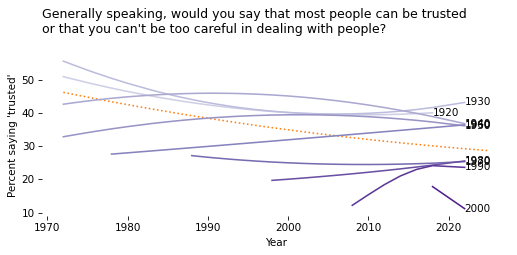

In [73]:
# Solution

pred_all.plot(ls=':', color='C1')

for cohort, color in zip(cohorts, colors):
    plot_cohort(gss, cohort, color)
    
decorate(
    xlabel="Year",
    ylabel=ylabel,
    title=question,
    legend=False
)

## Simpson's Paradox

The composition of the population changes over time.


In [74]:
# Solution

xtab_cohort = pd.crosstab(gss["cohort10"], gss["year"], normalize="columns")
xtab_cohort.head()

year,1972,1973,1974,1975,1976,1977,1978,1980,1982,1983,...,2004,2006,2008,2010,2012,2014,2016,2018,2021,2022
cohort10,,,,,,,,,,,,,,,,,,,,,
1880.0,0.003113,0.003995,0.008108,0.006739,0.004692,0.000000,0.003277,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1890.0,0.047945,0.038615,0.029730,0.037062,0.047587,0.027613,0.028834,0.017088,0.018929,0.005013,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1900.0,0.110212,0.099201,0.129730,0.082210,0.070375,0.091387,0.083224,0.059467,0.051379,0.038221,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1910.0,0.152553,0.158455,0.131081,0.130728,0.144772,0.125575,0.105505,0.124402,0.103840,0.093358,...,0.015714,0.007562,0.007944,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1920.0,0.224782,0.180426,0.193243,0.187332,0.159517,0.184747,0.152687,0.160629,0.149270,0.137218,...,0.038929,0.040036,0.038232,0.035294,0.025381,0.014235,0.009807,0.008576,0.0,0.0


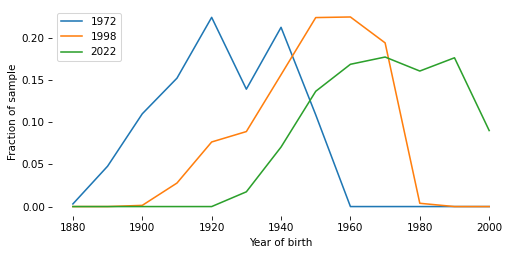

In [75]:
# Solution

xtab_cohort[1972].plot(label="1972")
xtab_cohort[1998].plot(label="1998")
xtab_cohort[2022].plot(label="2022")

decorate(xlabel="Year of birth", ylabel="Fraction of sample")

## Sampling weights

The GSS uses stratified sampling, so some respondents represent more people in the population than others.
We can use resampling to correct for stratified sampling.

In [76]:
# Solution

gss['wtssall'].describe()

count    72390.000000
mean         1.303960
std          0.889990
min          0.113721
25%          0.918400
50%          1.062700
75%          1.547800
max         14.272462
Name: wtssall, dtype: float64

In [77]:
# Solution

gss.groupby('year')['wtssall'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1972,1613.0,1.146481,0.486191,0.444600,0.889300,0.889300,1.333900,3.557100
1973,1504.0,1.130645,0.417802,0.457200,0.914500,0.914500,1.371700,2.743500
1974,1484.0,1.160032,0.443681,0.466000,0.932000,0.932000,1.397900,3.727900
1975,1490.0,1.140258,0.466167,0.466000,0.932000,0.932000,1.397900,3.261900
1976,1499.0,1.147392,0.459938,0.485400,0.970900,0.970900,1.456300,3.398100
1977,1530.0,1.161231,0.458057,0.494100,0.988100,0.988100,1.482200,2.964400
1978,1532.0,1.148797,0.448502,0.506300,1.012700,1.012700,1.519000,3.038000
1980,1468.0,1.168663,0.486058,0.511200,1.022500,1.022500,1.533700,3.578700
1982,1860.0,1.189170,0.513264,0.506400,1.031900,1.031900,1.547800,4.127500


In [78]:
def resample_by_year(df, column='wtssall'):
    """Resample rows within each year using weighted sampling.

    df: DataFrame
    column: string name of weight variable

    returns: DataFrame
    """
    grouped = df.groupby('year')
    samples = [group.sample(n=len(group), replace=True, weights=group[column])
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [118]:
# Solution

sample = resample_by_year(gss)

In [119]:
# Solution

sample['y'].mean()

np.float64(0.36038778568752344)

In [80]:
# Solution

gss['y'].mean()

np.float64(0.3701540842890312)

In [82]:
# Solution

weighted_mean = np.average(valid['y'], weights=valid['wtssall'])


Copyright 2025 Allen Downey 

The code in this notebook is under the [MIT license](https://mit-license.org/).